# Lab Six: CNNs
**- Wen Yang (47781972)**  
**- Ziling Feng (47781816)**  
**- Zheqi Wang (47711564)**  
**- Beichen Hu (47809766)**

## Business Description  
ASL stands for American Sign Language, ASL emerged as a language in the American School for the Deaf (ASD), founded in 1817. A reliable estimate for ASL users in the United States ranges from 250,000 to 500,000, including some deaf children. Moreover, ASL is not only important for deaf people, we believe that this language is also very important for children nowadays, and this language should be widely promoted to primary schools.  

There are 26 letters, A-Z, and three other gestures, which are spaces, nothing and delete, in our data package. There are 10,440 images, and all of them are 200*200 in size.  

I think the police will be interested in our prediction model. We think about this because we received the Amber alert on the phone previously, meaning that the children were kidnapped. If there is no way to cry out for help during the process of being kidnapped, ASL gestures would be useful. Children who have been kidnapped and learned ALS gestures can use ASL gestures anywhere in the camera and monitoring, such as SOS, surrounding conditions, etc. In this way, the police can take screenshots according to the camera and monitoring. Sometimes the pixels of the pictures are not so clear to recognize the gestures by people, then we can use our model. 
We could know the specific gestures through running the model in order to provide some clues and police could rescue them much faster.

## Preparation
### Evaluation Metrics

We used 'accuracy' as our evaluation metrics. Although there are 29 classes in our dataset this time (26 letters + space + nothing + delete), the proportion of important words described in the business description is more than 1/2 of the total words, such as HELP, SOS, RESCUE, etc. Therefore, the reason why we use 'accuracy' as evaluation metrics instead of cost metrics this time is that the larger proportion of the important letters need to be weighted, so it is not necessary to weight several important letters alone. Also, we don't want all the letters to be weighted because there are going to be some letters that are not weighted as much. Finally, accuracy is more objective. In terms of prediction results, it indicates how many samples with positive prediction are true positive samples, which is more consistent with the purpose of this experiment.

### Split Data

In this model, we decide to divide our data into training set and testing set with a ratio of 2:8. Because this time we used nearly 70,000 pieces of image data, which is a very large data set. So, we did not use the K-Fold approach to split data. The method of split data in ratio of 2:8 has ensured that each sub-data set in our data contains each class, and the number of image data in each class is relatively average, it is around 3000 images. If we use K-Fold to split data, we will spend a lot of time running the data in each Fold, therefore, using the former method will improve our efficiency.

### Data Preparation

For this part, we convert images to numpy array. Also we make every images a row preparing for latter process.  
Firstly, let's import the packages we need.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from PIL import Image
import copy
from pandas import DataFrame 

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model
keras.__version__

/Users/zheqiwang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.4'

In [3]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Then we print all category name. By the way, the ".DS_Store" is hidden folder for MacOS, which is useless for us. So we ignore this folder name.   
After this, we convert all images to numpy array and store in im_arr, corresponding lable name(folder name) storing in im_target. X_data stores original images.

In [5]:
for folder in os.listdir("asl_alphabet_train"): 
    if folder != ".DS_Store":
        print (folder)

R
U
I
N
G
Z
T
S
A
F
O
H
del
nothing
space
M
J
C
D
V
Q
X
E
B
K
L
Y
P
W


Because data type of the label is string, so we need to convert it into integer. To achieve this, we get characters ASCII then minus "A" ASCII, which means A-Z equals 0-25. "del" is 26, "space" is 27 and "nothing" is 28.

In [6]:
X_data = [] # store the pictures pixel data
im_arr=[]
im_target=[]

directory_name = "asl_alphabet_train"
for folder in os.listdir(directory_name):
    if folder != ".DS_Store":
        for filename in os.listdir(directory_name + "/" + folder):
            if filename != ".DS_Store":
                img = Image.open(directory_name + "/" + folder + "/" + filename)
                img = img.resize((32, 32),Image.ANTIALIAS)
                X_data.append(img)
                
                # convert A-Z to 1-26
                if folder == "del":
                    folder_num = 26
                elif folder == "space":
                    folder_num = 27
                elif folder == "nothing":
                    folder_num = 28
                else:
                    folder_num = ord(folder) - ord("A")                   
                # transfet image to numpy array
                im_arr.append(np.array(img)/255)
                im_target.append(folder_num)


In [7]:
print(len(im_arr))

87000


Then we convert all images' color into gray. Function **rgb2gray()** can achieve this.

In [8]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

im_grayarr=[] # gray image list
for im in im_arr:
    gray = rgb2gray(np.array(im))    
    im_grayarr.append(np.array(gray))
    
print(im_grayarr[0])

[[0.32012471 0.40155961 0.36266157 ... 0.38589294 0.41911725 0.40527412]
 [0.37826157 0.50520471 0.49232902 ... 0.44658078 0.51111451 0.47870431]
 [0.60397922 0.75898    0.67281647 ... 0.22758    0.26628471 0.28050588]
 ...
 [0.29985569 0.38860784 0.3787349  ... 0.54909843 0.57706039 0.51166157]
 [0.30821176 0.39881882 0.39493333 ... 0.58194235 0.60804941 0.53412549]
 [0.28107059 0.3632549  0.36655333 ... 0.5289898  0.5527949  0.49166196]]


In [9]:
X=np.array(im_grayarr)
y=np.array(im_target)
print(X.shape)
print(y.shape)
print(y)

(87000, 32, 32)
(87000,)
[17 17 17 ... 22 22 22]


Next, we split our data into training and testing set in the ratio of 2/8 and we set the number of class whcih is 29.

In [10]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NUM_CLASSES = 29

We display some images with plot gallery function.

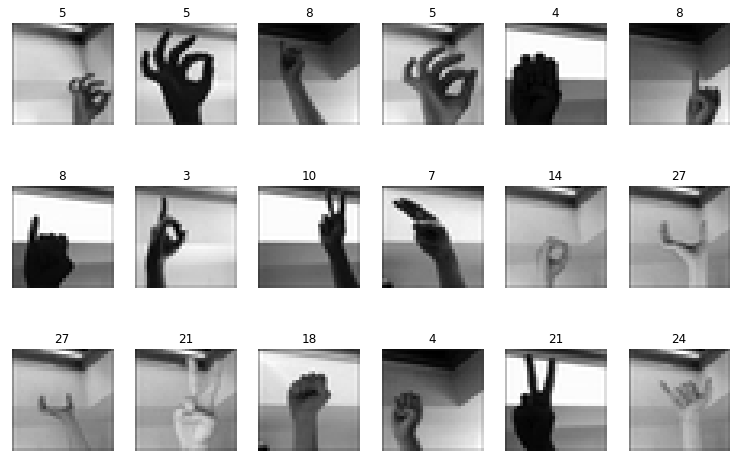

In [11]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 32, 32) # defaults to showing a 3 by 6 subset of the images

Then we fix our data size into 72*72. At the same time, we expand our data into four dimensions which we add one dimension to represent channel.

In [12]:
# NEW: Let's start by fixing the sizes
img_wh = 32
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
# the image data has been resized to (samples,image_rows,image_cols,image_channels)

In [13]:
print(y_train)
print(y_test)

[ 5  5  8 ... 21  3  4]
[17 21  4 ... 15 28  9]


Next, we change our target to one hot code.

In [14]:
y_train_ohe = keras.utils.to_categorical(np.array(y_train), NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(np.array(y_test), NUM_CLASSES)


print(X_train.shape)
print(X_test.shape)

print('New Shape: Rows: %d, image size: (%d,%d,%d)' % (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3] ))

(69600, 32, 32, 1)
(17400, 32, 32, 1)
New Shape: Rows: 69600, image size: (32,32,1)


In [15]:
y_test_ohe.shape

(17400, 29)

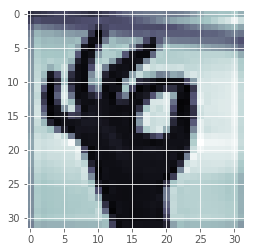

In [17]:
plt.subplot(1,1,1)
plt.imshow(X_train[1].squeeze(),cmap='bone')
plt.show()

## Modeling
### Two Layer CNN

We create two layers of convolutional neural network to use on our data using Keras. We have 32 filters in the first layer, and each filter is 3*3. And in second layer, the number of filter is 64, with the same size. Each layer is followed by Maxpooling.

In [18]:
%%time 

cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax


cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))  

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

CPU times: user 134 ms, sys: 85.6 ms, total: 219 ms
Wall time: 300 ms


In [19]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
__________

Then, we train the model using 10 epoches.

In [21]:
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
history_cnn = cnn.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=10, 
        shuffle=True, verbose=1,
        validation_data=(X_test,y_test_ohe),
        callbacks=[EarlyStopping(monitor='loss', patience=4)])

Train on 69600 samples, validate on 17400 samples
Epoch 1/10
69600/69600 [==============================] - 136s 2ms/step - loss: 1.6296 - acc: 0.4928 - val_loss: 0.5842 - val_acc: 0.8444
Epoch 2/10
69600/69600 [==============================] - 129s 2ms/step - loss: 0.7822 - acc: 0.7389 - val_loss: 0.2993 - val_acc: 0.9182
Epoch 3/10
69600/69600 [==============================] - 129s 2ms/step - loss: 0.6120 - acc: 0.7981 - val_loss: 0.3154 - val_acc: 0.9301
Epoch 4/10
69600/69600 [==============================] - 128s 2ms/step - loss: 0.5377 - acc: 0.8256 - val_loss: 0.1777 - val_acc: 0.9484
Epoch 5/10
69600/69600 [==============================] - 127s 2ms/step - loss: 0.5036 - acc: 0.8387 - val_loss: 0.1790 - val_acc: 0.9614
Epoch 6/10
69600/69600 [==============================] - 127s 2ms/step - loss: 0.4846 - acc: 0.8474 - val_loss: 0.1432 - val_acc: 0.9622
Epoch 7/10
69600/69600 [==============================] - 128s 2ms/step - loss: 0.4588 - acc: 0.8564 - val_loss: 0.0978 - 

Consindering the result, the val_accuracy increased with the epoch, and reach 0.95 finally. Also, the accuracy was already high enough at first, which is 0.84. And, the val_loss decreased at the same time. So, we think this two-layer CNN is a good model for now. 

In [22]:
yhat = cnn.predict(X_test,batch_size= 32)

In [23]:
print(yhat.shape)

(17400, 29)


Every letter has differnt performance and the accuracy is different. So, we choose ROC curve to represent the difference.<br />

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.
- The true-positive rate is also known as sensitivity, recall or probability of detection in machine learning.
- The false-positive rate is also known as the fall-out or probability of false alarm and can be calculated as (1 − specificity). 

An ROC curve demonstrates several things: 
- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.
- The area under the curve(AUC) is a measure of accuracy.

Reference: 
http://gim.unmc.edu/dxtests/roc2.htm  
https://www.youtube.com/watch?v=OAl6eAyP-yo

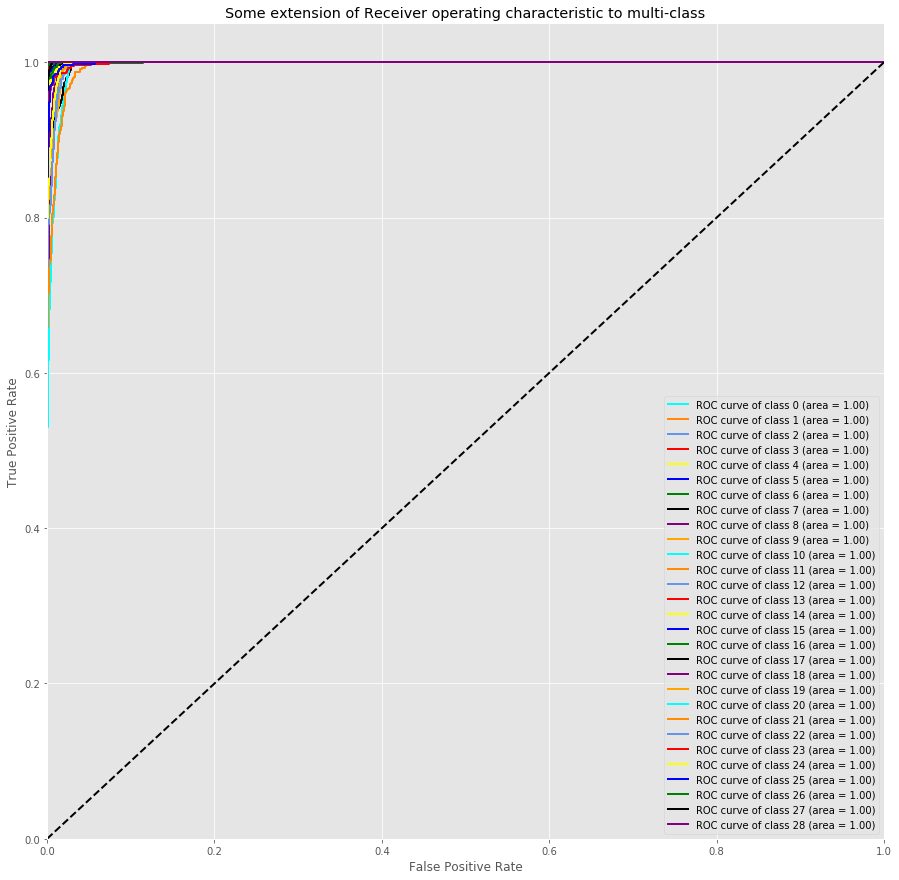

In [28]:
# reference: https://blog.csdn.net/xyz1584172808/article/details/81839230
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:,i], yhat[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure(figsize=(15,15))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','yellow','blue','green','black','purple','orange'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We could find every class has good performance, with a high True Positive Rate and low Flase Positive Rate. And every class has the area of 1, which means our model is so great with only 10 epoches!

In [29]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(30,15))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

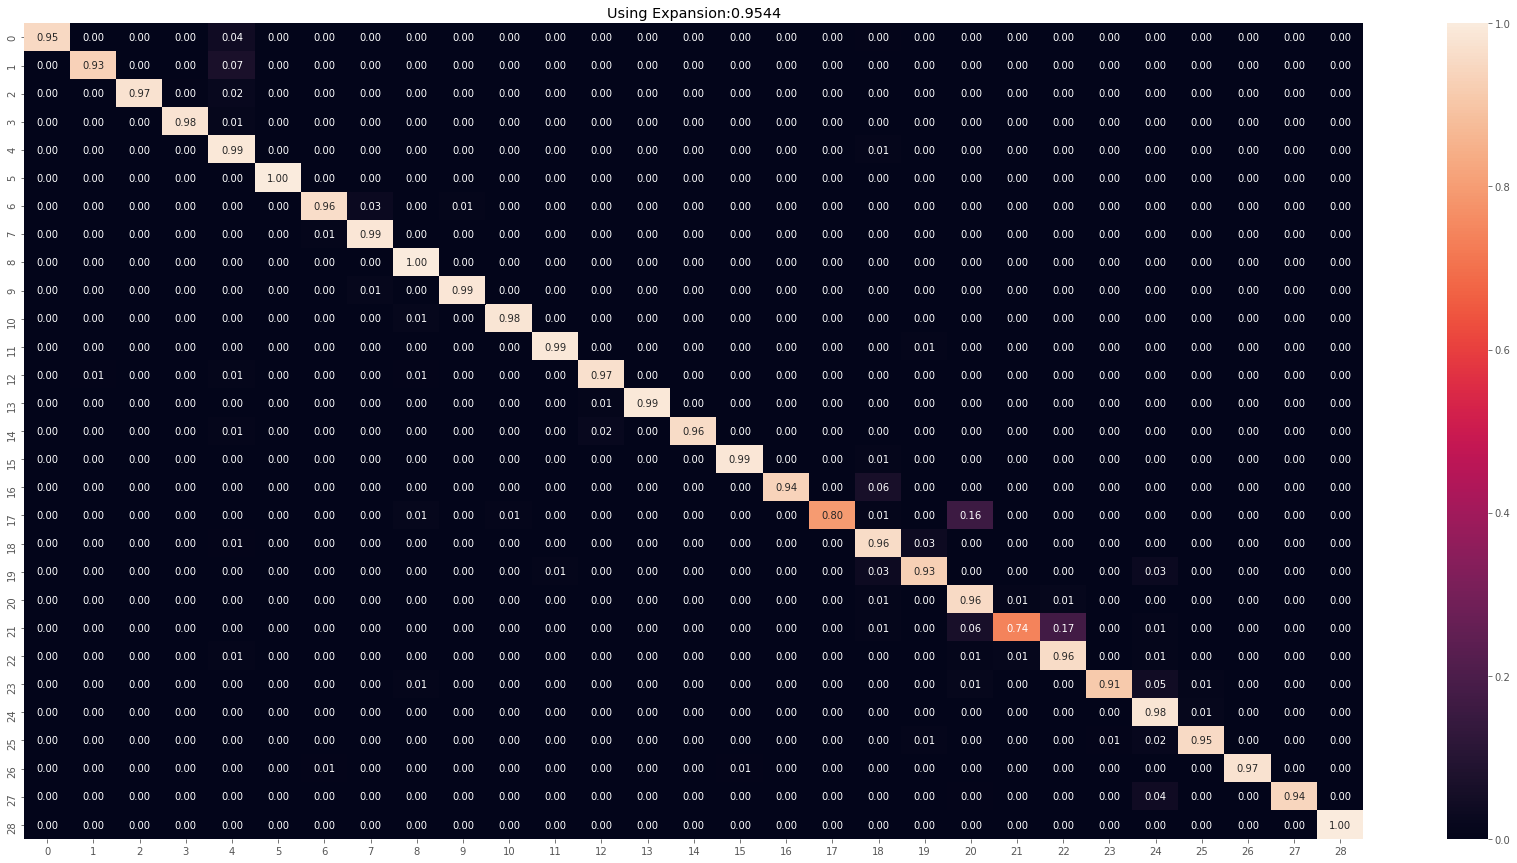

In [33]:
summarize_net(cnn, X_test, y_test, title_text='Using Expansion:')

We find almost every letter have high enough accuracy to not be confuced with other letters. But within the 17th and 20th letter, which is R and U, there is 16 percent probability to confuse those two characters. Also there is 17 percent probability to confused with 21th and 22th, which is V and W.  
We checked the images of these letters, and they actually seem similar to each other.

Text(0.5,0,'epochs')

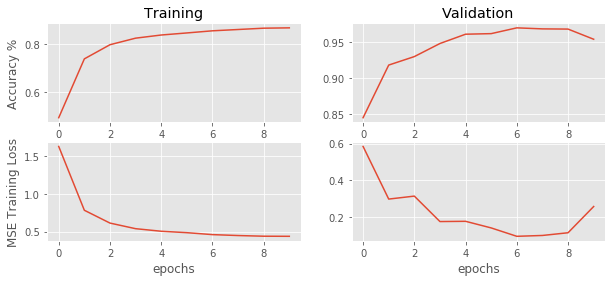

In [34]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_cnn.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history_cnn.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_cnn.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_cnn.history['val_loss'])
plt.xlabel('epochs')

After visualizing the performance of the CNN model, we found that gradient start convergence at about first epoch in validation and training. And within the validation, the Loss become increase and accuracy become decrease. We think it because overfitting.

## LeNet

We create LeNet to use on our data using Keras with 3 layers. We have 28 filters in the first layer, and each filter is 5*5. And in second layer, the number of filter is 10, with the same size. And 1 filter in third layer with the same size. First and second layer are followed by AveragePooling.

In [35]:
%%time
from keras.layers import AveragePooling2D

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model
from keras.regularizers import l2

l2_lambda = 0.000001
input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=28,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(5,5),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='tanh', 
               data_format="channels_last")(input_holder)

x = AveragePooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=10,
               kernel_size=(5,5),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='tanh', 
               data_format="channels_last")(x)

x = AveragePooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=1,
               kernel_size=(5,5),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='tanh', 
               data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(84)(x)
x = Activation("tanh")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

lenet = Model(inputs=input_holder,outputs=x)

lenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 28)        728       
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 28)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 10)        7010      
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 1)           251       
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
__________

Then, we train the model using 10 epoches.

In [36]:
# Let's train the model 
lenet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
history_lenet = lenet.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=10, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Train on 69600 samples, validate on 17400 samples
Epoch 1/10
69600/69600 [==============================] - 267s 4ms/step - loss: 3.0355 - acc: 0.1316 - val_loss: 2.5291 - val_acc: 0.2893
Epoch 2/10
69600/69600 [==============================] - 263s 4ms/step - loss: 2.5177 - acc: 0.2468 - val_loss: 2.2248 - val_acc: 0.3362
Epoch 3/10
69600/69600 [==============================] - 261s 4ms/step - loss: 2.2486 - acc: 0.3114 - val_loss: 1.8720 - val_acc: 0.4389
Epoch 4/10
69600/69600 [==============================] - 266s 4ms/step - loss: 2.0703 - acc: 0.3576 - val_loss: 1.6861 - val_acc: 0.4956
Epoch 5/10
69600/69600 [==============================] - 264s 4ms/step - loss: 1.9451 - acc: 0.3917 - val_loss: 1.5599 - val_acc: 0.5375
Epoch 6/10
69600/69600 [==============================] - 263s 4ms/step - loss: 1.8508 - acc: 0.4161 - val_loss: 1.4825 - val_acc: 0.5491
Epoch 7/10
69600/69600 [==============================] - 263s 4ms/step - loss: 1.7782 - acc: 0.4358 - val_loss: 1.4805 - 

Consindering the result, the val_accuracy increased with the epoch, and reach 0.58 finally, which is not enough. And, the val_loss decreased at the same time. Compared with the first model, this performance is much worse. So, we think this two-layer CNN is a better model for now. 

In [37]:
yhat_lenet = lenet.predict(X_test,batch_size= 32)

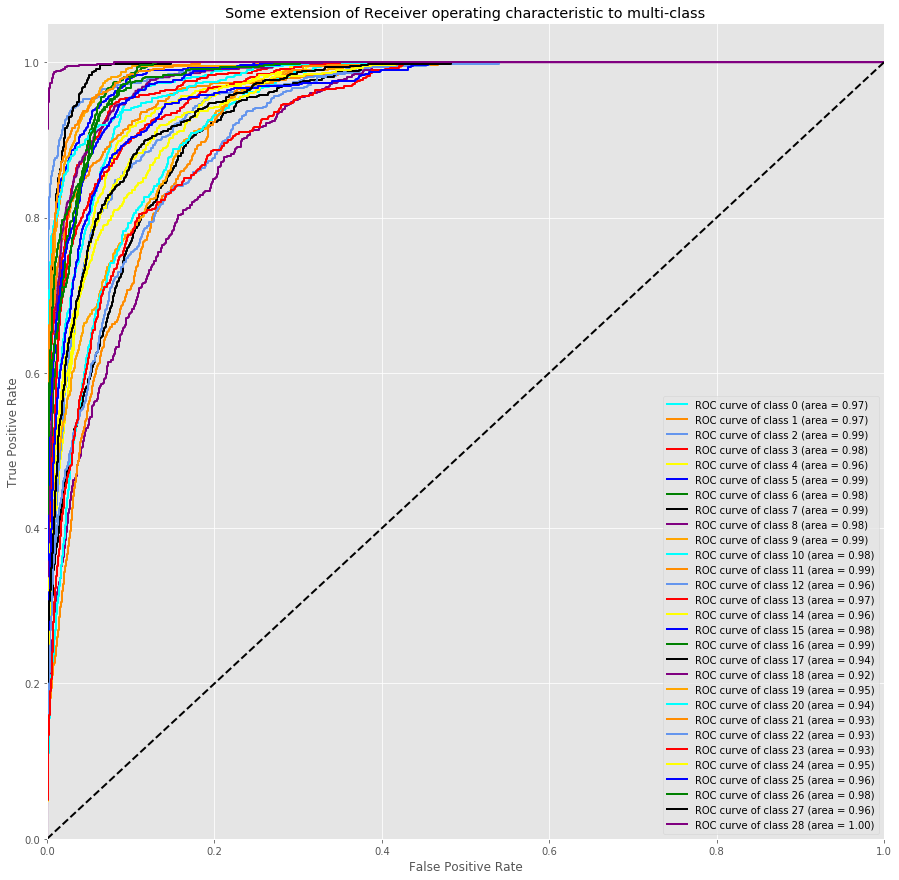

In [38]:
# reference: https://blog.csdn.net/xyz1584172808/article/details/81839230
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:,i], yhat_lenet[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure(figsize=(15,15))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','yellow','blue','green','black','purple','orange'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We could find every class has good performance, with a high True Positive Rate and low Flase Positive Rate. And every class has the area higher than 0.9, which means our model is great but not as good as the former one.

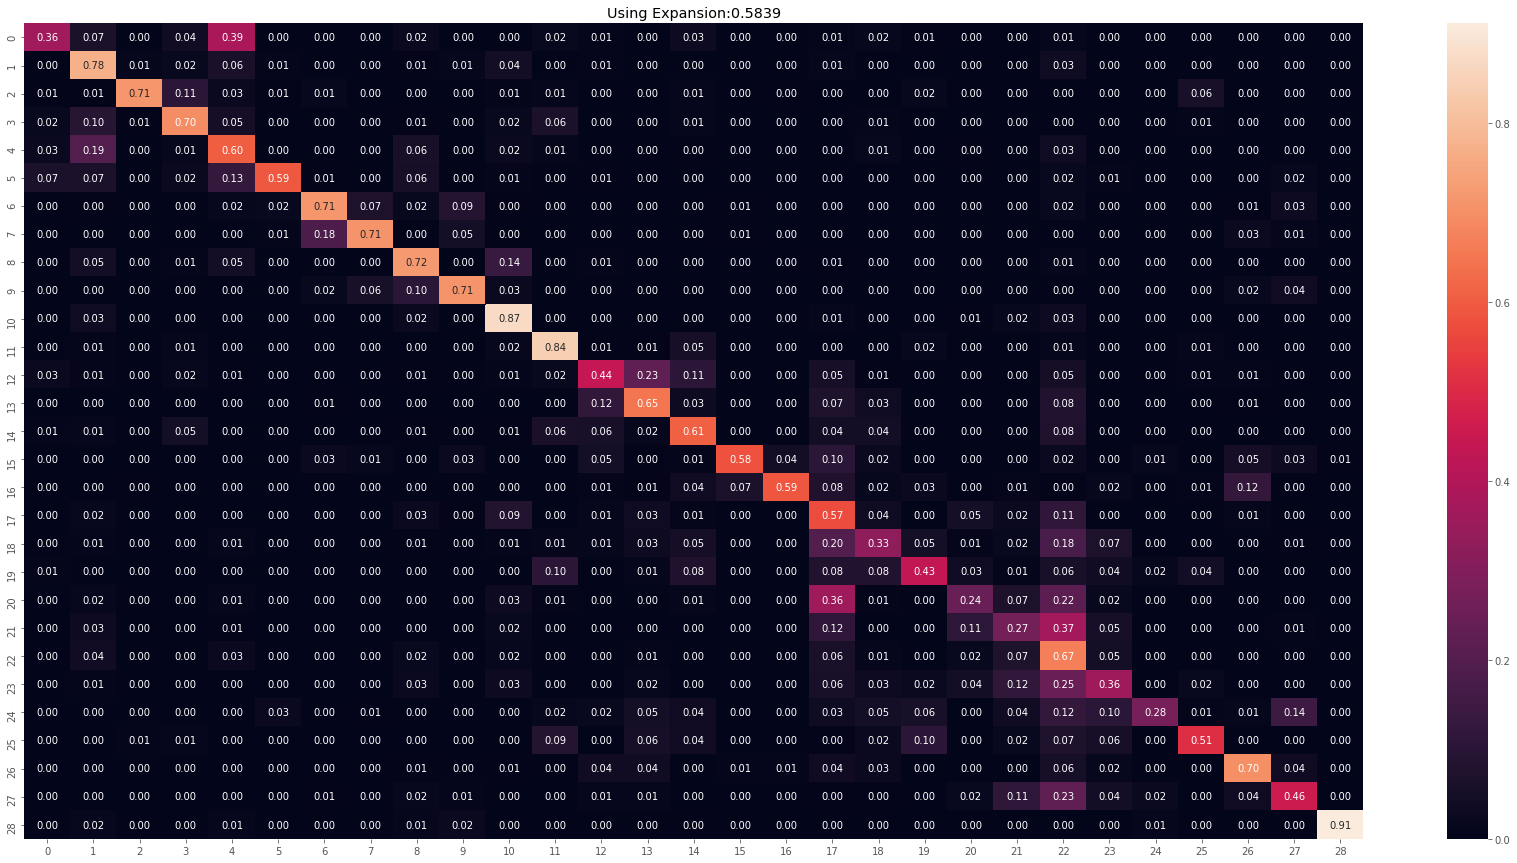

In [39]:
summarize_net(lenet, X_test, y_test, title_text='Using Expansion:')

We find accuracy of letter is not  high enough to be distinguished. The highest accuracy is 0.91 and the lowest accuracy is 0.24. And some letters have a high probability to be mixed.

Text(0.5,0,'epochs')

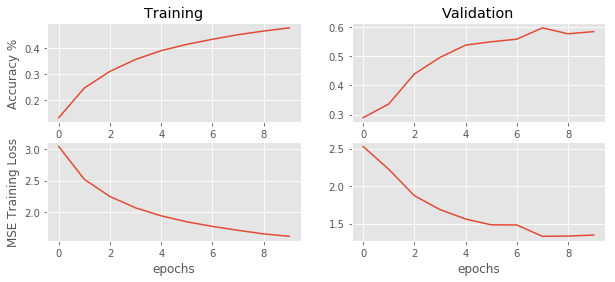

In [40]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_lenet.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history_lenet.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_lenet.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_lenet.history['val_loss'])
plt.xlabel('epochs')

After visualizing the performance of the LeNet model, we found that gradient start convergence at about fourth epoch in validation and training.

Compared with these two model, we could find the CNN model has the higher accuracy. The letters are easily to be distinguished in this model and convergence faster. So, we think CNN model is better.

# MLP

In this part, we create the MLP and then compare with CNN model.

In [41]:
row_arr=[]
for img in im_grayarr:
    one_img=[]
    for item in img:
        one_img.extend(item)
    # print(one_img)
    row_arr.append(one_img)
#print(row_arr[0])

In [42]:
X_mlp=np.array(row_arr)
y_mlp=np.array(im_target)
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_mlp, y_mlp, test_size=0.2)

In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt

mlp = MLPClassifier()
history_mlp = mlp.fit(X_train_mlp, y_train_mlp)

In [47]:
yhat_mlp = mlp.predict(X_test_mlp)

In [57]:
print(y_test_mlp)
print(yhat_mlp)

[19 10  6 ...  3 22 19]
[19 21  6 ...  3 21 19]


In [58]:
y_test_mlp_ohe = keras.utils.to_categorical(np.array(y_test_mlp), NUM_CLASSES)
yhat_mlp_ohe = keras.utils.to_categorical(np.array(yhat_mlp), NUM_CLASSES)

print(y_test_mlp_ohe.shape)
print(yhat_mlp_ohe.shape)

(17400, 29)
(17400, 29)


We draw the ROC Curve plot. To draw ROC curve, we transfer the output of predict function into one hot encode to show the different letters accuracy.

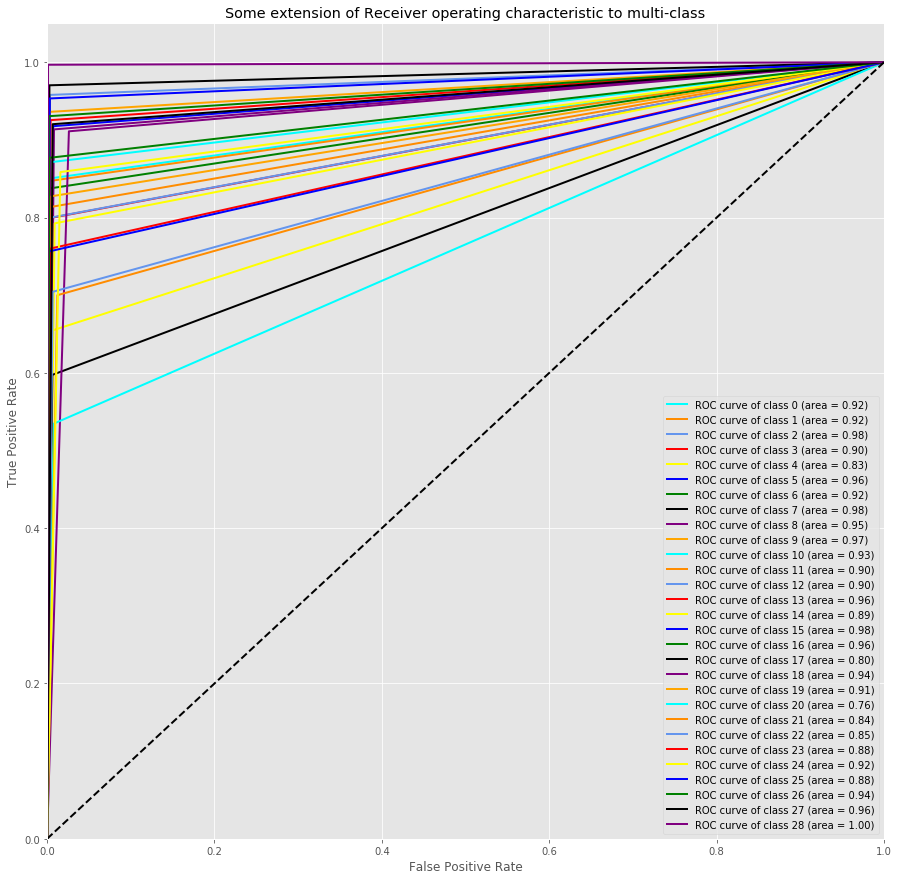

In [59]:
# reference: https://blog.csdn.net/xyz1584172808/article/details/81839230

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_mlp_ohe[:,i], yhat_mlp_ohe[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure(figsize=(15,15))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','yellow','blue','green','black','purple','orange'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We could find every class has different performance, with a high True Positive Rate and low Flase Positive Rate. And every class has the area higher than 0.9, and the highest area reached 1.

Although the performance of MLP is pretty good, it is not good enough when compared with CNN's ROC Curve plot. So, we think two-layer CNN model is more suitable for our data set.

## Exceptional Work

In this time, we use ResNet50 to pre-train our data set.  
Our mission is to build a convolutional network before the deadline. I think we need to spend a few hours or even days to "train" our model, if you want to build a model to train again, this will become a mission impossible before deadline. At this time, transfer learning came to save us. So, we have decided to use the model which has been trained by other people, 'resnet50' to pre-train our data. The trained model have some understanding of the images, and final output layer of the model is to classify the former pictures. However, for now, calculation of the value of our task is useless. So, we replaced ResNet50's with our model's full connected layer. Then we only need to use our data to train model, and always keep the same understanding. The parameters in front of convolutional layer need not to be trained again, which saved us a lot of time. We also can meet in the deadline time. Therefore, if there are some same type of problems, we don't have to train again completely, just need to learn from other's experience and models, it usually saves a lot of time. Such being the case, we don't have to spend time to train a tremendous neural network, only need to draw lessons from an already exited convolutional neural network.  
In this part, we need to use original color data images. Also, we split the data into training and data set in ratio 2/8 again.  

In [9]:
from sklearn.model_selection import train_test_split
X = np.array(im_arr)
y = np.array(im_target)
print(X.shape)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.2)

(87000, 32, 32, 3)


But we still need to change target into one hot code.

In [11]:
from keras.utils import to_categorical

NUM_CLASSES = 29
y_train1_ohe = to_categorical(y_train1, NUM_CLASSES)
y_test1_ohe = to_categorical(y_test1, NUM_CLASSES)
print(X_train1.shape)
print(X_test1.shape)
print(y_train1_ohe.shape)
print(y_test1_ohe.shape)


(69600, 32, 32, 3)
(17400, 32, 32, 3)
(69600, 29)
(17400, 29)


Then we resize our image data size to 63*63.

In [12]:
%%time
# from skimage.transform import resize
from scipy.misc import imresize
import numpy as np


x_train_up = [imresize(x, size=(64,64,3), interp='nearest') for x in X_train1]
x_train_up = np.stack(x_train_up, axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x, size=(64,64,3), interp='nearest') for x in X_test1]
x_test_up = np.stack(x_test_up, axis=0)
print(x_test_up.shape)

/Users/zheqiwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


(69600, 64, 64, 3)


/Users/zheqiwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


(17400, 64, 64, 3)
CPU times: user 15.8 s, sys: 5.82 s, total: 21.6 s
Wall time: 34.9 s


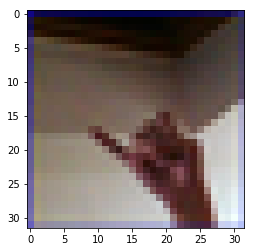

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
# from skimage.io import imshow
idx = 5
plt.imshow((X_train1[idx]-X_train1[idx].min())/(X_train1[idx].max()-X_train1[idx].min()))
plt.grid(False)

In [14]:
x_train_up[0].max()

255

We load only convolutional layers of resnet to pre-train our dataset. 

In [15]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = x_train_up[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time 
preds = res_no_top.predict(x)
preds.shape

/Users/zheqiwang/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


(1, 2, 2, 2048)

In [16]:
x_train_up = preprocess_input(x_train_up)
x_test_up = preprocess_input(x_test_up)

In [18]:
%%time

# train on half the data, to save a few hours
x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)
print(x_train_resnet.shape)

(69600, 2, 2, 2048)
CPU times: user 50min 34s, sys: 48.6 s, total: 51min 22s
Wall time: 54min 23s


In [20]:
print(x_test_resnet.shape)
#print(y_test_ohe[:x_test_resnet.shape[0]].shape)

(17400, 2, 2, 2048)


In [22]:
print(y_test1_ohe.shape)

(17400, 29)


After pre-train our dataset, we add it into fully connected layer. This part is same architecture as the two layer CNN's fully connected layer.

In [23]:
input_x = Input(shape=x_train_resnet[0].shape)
x = Dropout(0.25)(input_x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2, 2, 2048)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                3741      
Total para

Then we trained model.

In [26]:
y_train1_ohe_resnet = y_train1_ohe[:x_train_resnet.shape[0]]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

history_resnet = model.fit(x_train_resnet,y_train1_ohe_resnet,epochs=10,
          batch_size=32,verbose=1,
         validation_data=(x_test_resnet, y_test1_ohe[:x_test_resnet.shape[0]]))

Train on 69600 samples, validate on 17400 samples
Epoch 1/10
69600/69600 [==============================] - 100s 1ms/step - loss: 1.5143 - acc: 0.5566 - val_loss: 0.4045 - val_acc: 0.8807
Epoch 2/10
69600/69600 [==============================] - 94s 1ms/step - loss: 0.8932 - acc: 0.7443 - val_loss: 0.2444 - val_acc: 0.9290
Epoch 3/10
69600/69600 [==============================] - 81s 1ms/step - loss: 0.7413 - acc: 0.8006 - val_loss: 0.2010 - val_acc: 0.9432
Epoch 4/10
69600/69600 [==============================] - 82s 1ms/step - loss: 0.7020 - acc: 0.8216 - val_loss: 0.1721 - val_acc: 0.9494
Epoch 5/10
69600/69600 [==============================] - 80s 1ms/step - loss: 0.6808 - acc: 0.8348 - val_loss: 0.1592 - val_acc: 0.9544
Epoch 6/10
69600/69600 [==============================] - 80s 1ms/step - loss: 0.6848 - acc: 0.8433 - val_loss: 0.1386 - val_acc: 0.9628
Epoch 7/10
69600/69600 [==============================] - 81s 1ms/step - loss: 0.6656 - acc: 0.8515 - val_loss: 0.1369 - val_ac

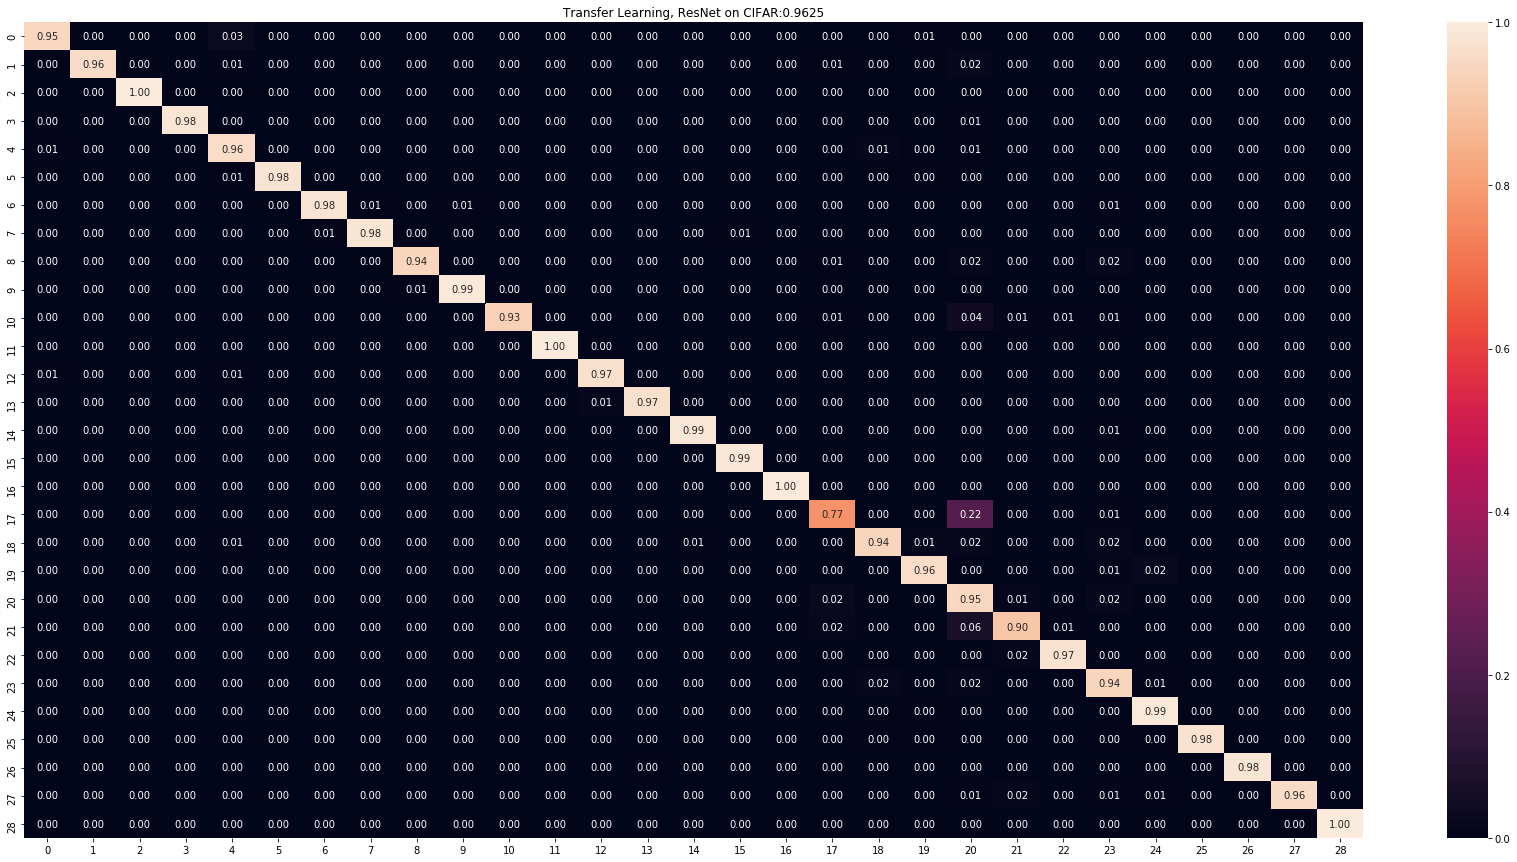

In [33]:
summarize_net(model, x_test_resnet, y_test1[:x_test_resnet.shape[0]], title_text='Transfer Learning, ResNet on CIFAR:')

Text(0.5,0,'epochs')

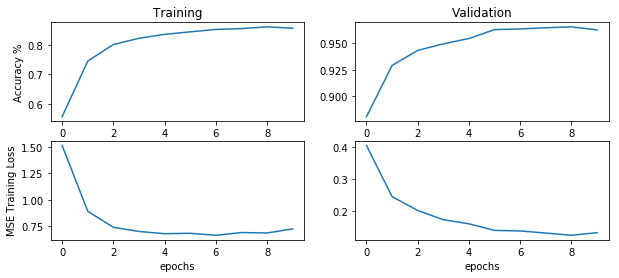

In [28]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_resnet.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history_resnet.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_resnet.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_resnet.history['val_loss'])
plt.xlabel('epochs')

From the plots shown above, in ROC curve, the accuracy is pretty well, around 96%. This model confused with 20th and 17th letters, which is the same as two layer CNN model.  
Comparing the Validation plot with no-preprocess two layer CNN, pre-trained CNN converge in the 4th epoch and which is better is that pre-trained CNN has no overfitting at 8th epoch. 
So our conclusion is with pre-trained dataset, the CNN model could do better than no-preprocess.